In [22]:
import requests
import json
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import pytrec_eval
import scipy.stats as stats

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
test_in = '/mnt/scratch/chenqu/aol/original/session_test.txt'
encoding_in = '/mnt/scratch/chenqu/aol/original/session_test.gen.encoding.txt'
sim_out = '/mnt/scratch/chenqu/aol/original/session_test.sim.json'

In [3]:
def cos_sim(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
# check if embeddings are obtained from the api

In [14]:
sessions = {}
with open(test_in) as fin:
    for line in tqdm(fin):
        session = json.loads(line.strip())
        session_id = session['session_id']
        session_len = len(session['query'])
        sessions[session_id] = {'len': session_len, 'has_encoding': False, 'right_len': False}

29369it [00:03, 7411.61it/s]


In [15]:
with open(encoding_in) as fin:
    for line in tqdm(fin):
        session = json.loads(line.strip())
        session_id = session['session_id']
        session_len = len(session['vectors'])
        sessions[session_id]['has_encoding'] = True
        if session_len == sessions[session_id]['len']:
            sessions[session_id]['right_len'] = True

29369it [00:01, 18900.63it/s]


In [16]:
for session_id, value in sessions.items():
    if not value['has_encoding'] or not value['right_len']:
        print(session_id, value)

In [ ]:
# generate figure for MRR improvement -- cos sim

In [4]:
qids = []
with open(test_in) as fin:
    for line in tqdm(fin):
        session = json.loads(line.strip())
        session_id = session['session_id']
        for turn_id, turn in enumerate(session['query']):
            qids.append((session_id, turn_id))

29369it [00:03, 7467.30it/s]


In [5]:
sim_dict = {}
N = 3
with open(encoding_in) as fin:
    for line in tqdm(fin):
        session = json.loads(line.strip())
        session_id = session['session_id']
        vectors = session['vectors']
        for turn_id, vector in enumerate(vectors):
            if turn_id == 0:
                continue
            start = turn_id - N
            start = max(start, 0)
            prev_vectors = vectors[start: turn_id]
            assert len(prev_vectors) <= N
            sims = []
            for prev_vector in prev_vectors:
                sims.append(cos_sim(vector, prev_vector))
            sim_dict[(session_id, turn_id)] = np.average(sims)
                

29369it [00:03, 7663.08it/s]


In [6]:
def trec_eval(qrels, run):
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, {'recip_rank'})
    res = evaluator.evaluate(run)
    mrr_list = [v['recip_rank'] for k, v in res.items() if k.split('_')[1] != '0']
    return mrr_list

In [7]:
ours_file = '/mnt/scratch/chenqu/stateful_search/97/test_preds.txt'
baseline_file = '/mnt/scratch/chenqu/stateful_search/43/test_preds.txt'

with open(ours_file) as fin:
    ours = json.load(fin)
    ours_mrr_list = trec_eval(ours['qrels'], ours['run'])
    
with open(baseline_file) as fin:
    baseline = json.load(fin)
    baseline_mrr_list = trec_eval(baseline['qrels'], baseline['run'])



In [8]:
mrr_diff_list = np.array(ours_mrr_list) - np.array(baseline_mrr_list)

In [9]:
len(mrr_diff_list)

46790

0.20033970819541758 4679 0.005673827351366683
0.36996286922624905 4679 0.017958763900479742
0.5039782317969964 4679 0.015236556358338415
0.6291492068846768 4679 0.023553148278523513
0.7542247228072627 4679 0.03321970064570674
0.89284997779234 4679 0.05194147253246994
0.99938331322083 4679 0.05526290738799895
0.9999999998999999 4679 0.053846774048799416
0.9999999998999999 4679 0.0481697285687406
0.9999999998999999 4679 0.05212545042217909


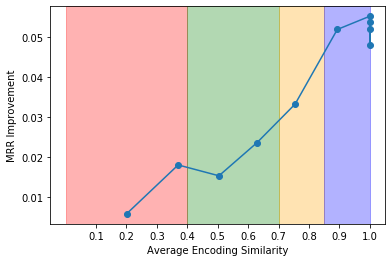

In [10]:
query_level_avg_gen_sim = np.array(list(sim_dict.values()))
query_level_avg_gen_sim[query_level_avg_gen_sim >= 0.9999999999] = 0.9999999999

# group by quantile
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
sim_mrr = []
sort_idx = np.argsort(query_level_avg_gen_sim)
mrr_diff_list_sorted = mrr_diff_list[sort_idx]
query_level_avg_gen_sim_sorted = query_level_avg_gen_sim[sort_idx]
chunk_size = 4679

xs = []
for mrrs, sims in zip(chunks(mrr_diff_list_sorted, chunk_size), chunks(query_level_avg_gen_sim_sorted, chunk_size)):
    sim_mrr.append(np.average(mrrs))
    xs.append(round(np.average(sims), 4))
    print(np.average(sims), len(sims), np.average(mrrs))
    
# from scipy.interpolate import make_interp_spline, BSpline
# xnew = np.linspace(min(xs), max(xs),100) #300 represents number of points to make between T.min and T.max
# spl = make_interp_spline(xs, sim_mrr, k=2) #BSpline object #########################
# power_smooth = spl(xnew)
# plt.plot(xnew,power_smooth, color='green')
    
plt.plot(xs, sim_mrr, marker='o')
plt.xticks(np.arange(1, 11) * 0.1)

plt.axvspan(0.0, 0.4, alpha=0.3, color='red', label='TopicChange')
plt.axvspan(0.4, 0.7, alpha=0.3, color='green', label='Explore')
plt.axvspan(0.7, 0.85, alpha=0.3, color='orange', label='Specify')
plt.axvspan(0.85, 1, alpha=0.3, color='blue', label='Paraphrase')
# plt.legend(prop={'size': 15}, bbox_to_anchor=(1, 1.3), ncol=2)
# plt.legend(prop={'size': 16})

plt.xlabel('Average Encoding Similarity')
plt.ylabel('MRR Improvement')
# plt.savefig('figures/{}.pdf'.format('embed'), format='pdf', bbox_inches='tight')
plt.show()

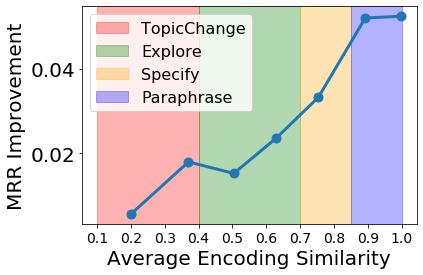

In [23]:
edited_sim_mrr = sim_mrr[:-4] + [sum(sim_mrr[-4:]) / 4]
edited_xs = xs[:-4] + [sum(xs[-4:]) / 4]

plt.plot(edited_xs, edited_sim_mrr, marker='o', linewidth=3, markersize=9)
plt.xticks(np.arange(1, 11) * 0.1)

plt.axvspan(0.1, 0.4, alpha=0.3, color='red', label='TopicChange')
plt.axvspan(0.4, 0.7, alpha=0.3, color='green', label='Explore')
plt.axvspan(0.7, 0.85, alpha=0.3, color='orange', label='Specify')
plt.axvspan(0.85, 1, alpha=0.3, color='blue', label='Paraphrase')
# plt.legend(prop={'size': 15}, bbox_to_anchor=(1, 1.3), ncol=2)
plt.legend(prop={'size': 16})

plt.xlabel('Average Encoding Similarity')
plt.ylabel('MRR Improvement')
plt.tick_params(axis="x", labelsize=14)
plt.savefig('figures/fine.pdf', format='pdf', bbox_inches='tight')
plt.show()

-0.2 0.0 59 -0.04889446551365051
0.0 0.2 1935 0.005609521936177791
0.2 0.4 6004 0.011000494880230206
0.4 0.6000000000000001 7269 0.018376649693861765
0.6000000000000001 0.8 7476 0.029005401320917445
0.8 1.0 24047 0.05181134960965139


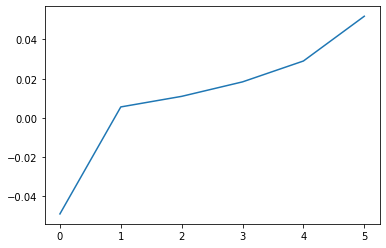

In [13]:
sim_mrr = []

th = -0.2
gap = 0.2
while th < 1.0:
    idx = (th <= query_level_avg_gen_sim) & (query_level_avg_gen_sim < th + gap) 
    sim_mrr_datapoint = np.average(mrr_diff_list[idx])
    sim_mrr.append(sim_mrr_datapoint)
    print(th, th + gap, sum(idx), sim_mrr_datapoint)
    th += gap
    
plt.plot(sim_mrr)
plt.show()

-0.5 0.4 7998 0.009254391440622756
0.4 0.7 11045 0.021252986733106785
0.7 0.85 5412 0.031590895895592254
0.85 1 22335 0.05330748170624747


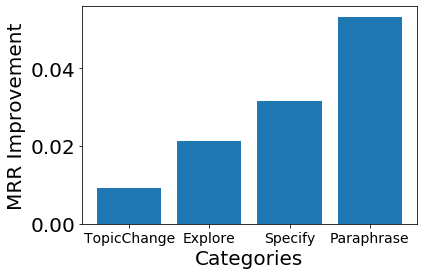

In [31]:
sim_mrr = []

for th1, th2 in zip([-0.5, 0.4, 0.7, 0.85], [0.4, 0.7, 0.85, 1]):
    idx = (th1 < query_level_avg_gen_sim) & (query_level_avg_gen_sim <= th2) 
    sim_mrr_datapoint = np.average(mrr_diff_list[idx])
    sim_mrr.append(sim_mrr_datapoint)
    print(th1, th2, sum(idx), sim_mrr_datapoint)
    
plt.bar(['TopicChange', 'Explore', 'Specify', 'Paraphrase'], sim_mrr)
plt.ylabel('MRR Improvement')
plt.xlabel('Categories')
plt.tick_params(axis="x", labelsize=14)
plt.savefig('figures/coarse.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# generate figure for aol similarity distribution

In [16]:
sims = [[], [], []] # dist=0, 1, 2
all_vectors = []
random = []

with open(encoding_in) as fin:
    for line in tqdm(fin):
        session = json.loads(line.strip())
        session_id = session['session_id']
        vectors = session['vectors']
        for turn_id, vector in enumerate(vectors):
            all_vectors.append(vector)
            if turn_id == 0:
                continue
            start = 0
            prev_vectors = vectors[start: turn_id]
            
            for prev_turn_id, prev_vector in enumerate(prev_vectors):
                dist = turn_id - prev_turn_id - 1
                if dist in [0, 1, 2]:
                    sims[dist].append(cos_sim(vector, prev_vector))


29369it [00:03, 7607.58it/s]


In [17]:
np.random.seed(0)
dist_0 = np.random.choice(sims[0], 5000, replace=False)
np.random.seed(0)
dist_1 = np.random.choice(sims[1], 5000, replace=False)
np.random.seed(0)
dist_2 = np.random.choice(sims[2], 5000, replace=False)

dist_random = []
all_idx = list(range(len(all_vectors)))
for i in tqdm(range(5000)):
    np.random.seed(i)
    idx = np.random.choice(all_idx, 2, replace=False)
    sim = cos_sim(all_vectors[idx[0]], all_vectors[idx[1]])
    dist_random.append(sim)

100%|██████████| 5000/5000 [00:31<00:00, 159.43it/s]


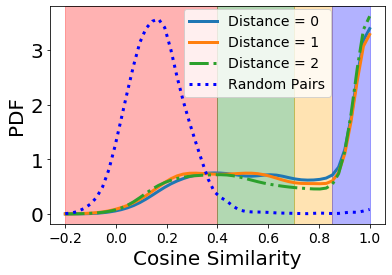

In [24]:
density_0 = stats.gaussian_kde(dist_0)
n_0, x_0, _ = plt.hist(dist_0, bins=np.linspace(-0.2, 1, 50), density=True)  
density_1 = stats.gaussian_kde(dist_1)
n_1, x_1, _ = plt.hist(dist_1, bins=np.linspace(-0.2, 1, 50), density=True)
density_2 = stats.gaussian_kde(dist_2)
n_2, x_2, _ = plt.hist(dist_2, bins=np.linspace(-0.2, 1, 50), density=True)
density_random = stats.gaussian_kde(dist_random)
n_random, x_random, _ = plt.hist(dist_random, bins=np.linspace(-0.2, 1, 50), density=True)
plt.clf()
plt.plot(x_0, density_0(x_0), label='Distance = 0', ls='-', linewidth=3)
plt.plot(x_1, density_1(x_1), label='Distance = 1', ls='-', linewidth=3)
plt.plot(x_2, density_2(x_2), label='Distance = 2', ls='-.', linewidth=3)
plt.plot(x_random, density_random(x_random), label='Random Pairs', ls=':', color='blue', linewidth=3)

# plt.hist(dist_0, label='distance = 0')
# plt.hist(dist_1, label='distance = 1')
# plt.hist(dist_2, label='distance = 2')
# plt.xticks(np.arange(1, 11) * 0.1)

plt.axvspan(-0.2, 0.4, alpha=0.3, color='red')
plt.axvspan(0.4, 0.7, alpha=0.3, color='green')
plt.axvspan(0.7, 0.85, alpha=0.3, color='orange')
plt.axvspan(0.85, 1, alpha=0.3, color='blue')
# plt.legend(prop={'size': 15}, bbox_to_anchor=(1, 1.3), ncol=2)
plt.legend(prop={'size': 14}, bbox_to_anchor=(0.86, 0.55))

plt.xlabel('Cosine Similarity')
plt.ylabel('PDF')
plt.tick_params(axis="x", labelsize=14)
plt.savefig('figures/aol.pdf', format='pdf', bbox_inches='tight')
plt.show()

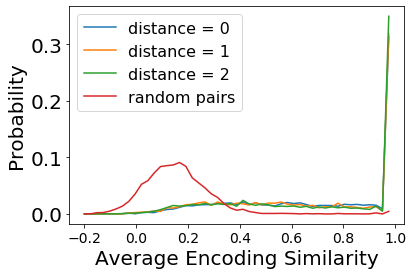

In [42]:
n_0, x_0, _ = plt.hist(dist_0, bins=np.linspace(-0.2, 1, 50), density=False, 
                       weights=np.ones(len(dist_0)) / len(dist_0))
n_1, x_1, _ = plt.hist(dist_1, bins=np.linspace(-0.2, 1, 50), density=False, 
                       weights=np.ones(len(dist_1)) / len(dist_1))
n_2, x_2, _ = plt.hist(dist_2, bins=np.linspace(-0.2, 1, 50), density=False, 
                       weights=np.ones(len(dist_2)) / len(dist_2))
n_r, x_r, _ = plt.hist(dist_random, bins=np.linspace(-0.2, 1, 50), density=False, 
                       weights=np.ones(len(dist_random)) / len(dist_random))
plt.clf()
plt.plot(x_0[:49], n_0, label='distance = 0')
plt.plot(x_1[:49], n_1, label='distance = 1')
plt.plot(x_2[:49], n_2, label='distance = 2')
plt.plot(x_r[:49], n_r, label='random pairs')
plt.legend(prop={'size': 16})
plt.xlabel('Average Encoding Similarity')
plt.ylabel('Probability')
plt.tick_params(axis="x", labelsize=14)
plt.show()

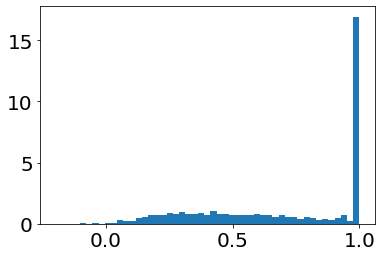

In [73]:
density_0 = stats.gaussian_kde(dist_0)
n_2, x_2, _ = plt.hist(dist_2, bins=np.linspace(-0.2, 1, 50), density=True)
plt.show()